# AirMSPI Space Carving
---

This notebook demonstrates Space-Carving [[1]] of the convex hull of a 3D cloud using AirMSPI data of a scene above the north Pacific ocean [[2]]. Out of the entire cloud field a single isolated cloud was cropped using `scripts/airmspi_crop_data.py`. The data was pre-processed using `notebooks/AirMSPI Preprocessing.ipynb` to compensate for cloud motion that occurs during acquisition. 

**Note that the compensation is mainly for across-track as the along-track motion can not be easily disambiguated from parallax.**

[1]: https://webee.technion.ac.il/~yoav/publications/Veikherman_Clouds_inthe_cloud.pdf

[2]: https://asdc.larc.nasa.gov/documents/airmspi/images/ELLIPSOID/AirMSPI_ER2_GRP_ELLIPSOID_20130206_202754Z_NorthPacificOcean-32N123W_000N_F01_V005.jpg

In [9]:
import numpy as np
import pyshdom
import matplotlib.pylab as plt
import xarray as xr
import glob

%matplotlib notebook

In [10]:
def project_to_altitude(theta, phi, alt):
    tan_theta = np.tan(np.deg2rad(theta)) * alt
    delta_x = tan_theta * np.cos(np.deg2rad(phi))
    delta_y = tan_theta * np.sin(np.deg2rad(phi))
    return delta_x, delta_y

In [48]:
"""
Azimuth is measured from North and X is pointing East (ENU coordinates).
https://asdc.larc.nasa.gov/documents/airmspi/guide/AirMSPI_Cloud_Droplet_ATBD.20180117.pdf
"""
datapath = '../data/airmspi/26-May-2021-18:56:49_Preprocessed*'
files = glob.glob(datapath)

toa = 10.0         # [km]
wavelength = 0.935 # [micron]
stokes = 'I'    

oblique_tresh = 9.0e-3
radiance_tresh = 5.5e-3

# Translate coordinates to start at (0,0)
x0, y0 = -0.88, -1.28
    
sensor_list = []
for file in files:
    data = xr.load_dataset(file, group='radiance').sel(band='935nm')
    
    zenith = data['View_zenith']
    azimuth = 90 - data['View_azimuth']
    x, y = np.meshgrid(data['XDim'], data['YDim'])
    dx, dy = pyshdom.preprocessing.project_to_altitude(zenith, azimuth, toa)
    x = (x + dx).values.ravel() - x0
    y = (y + dy).values.ravel() - y0
    z = np.full_like(x, fill_value=toa)
    mu = np.cos(np.deg2rad(zenith.values.ravel()))
    phi = np.deg2rad(azimuth.values.ravel())
    pixels = data.I.values.ravel()
    pixels = pixels[np.isfinite(pixels)]
    
    sensor = pyshdom.sensor.make_sensor_dataset(
        x[np.isfinite(x)], y[np.isfinite(y)], z[np.isfinite(x)], mu[np.isfinite(mu)], 
        phi[np.isfinite(phi)], stokes, wavelength, fill_ray_variables=True)
    
    # Generate cloud masks
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask = np.zeros(sensor.sizes['nrays'], dtype=np.int)
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=np.int)
    threshold = oblique_tresh if data.view_angle in ['661F', '661A'] else radiance_tresh
    ray_mask_pixel[np.where(pixels > threshold)] = 1
    sensor['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    
    sensor_list.append(sensor)

In [71]:
rte_grid = pyshdom.grid.make_grid(0.05, 42, 0.05, 55, np.linspace(0.9,2.0,23))
space_carver = pyshdom.space_carve.SpaceCarver(rte_grid)
volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0))

<IPython.core.display.Javascript object>


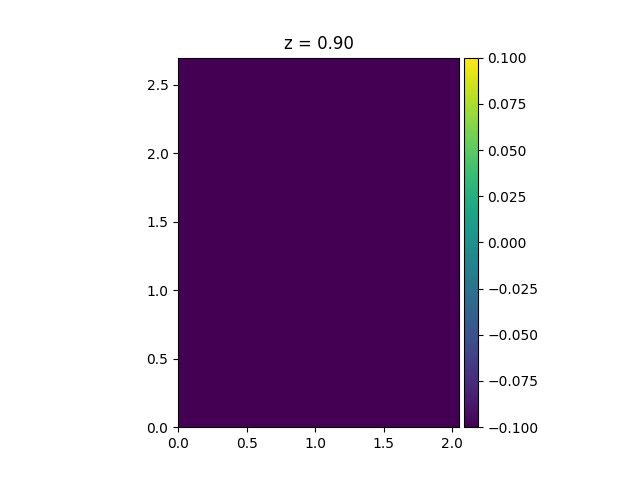

interactive(children=(IntSlider(value=11, description='frame', max=22), Output()), _dom_classes=('widget-inter…

In [72]:
volume.mask.visualization.slider(dim='z')

In [75]:
volume.attrs.update(agreement='(0.0, 1.0)')
volume.to_netcdf('../data/airmspi/26-May-2021-18:56:49_Spacecarved_Volume.nc')